In [1]:
import os; print(os.getcwd())

C:\Users\enjol\OneDrive\Desktop\Medical Economics\SLAbreach\notebooks


In [2]:
import sys, sklearn, numpy
print("Python:", sys.executable)
print("sklearn:", sklearn.__version__)
print("numpy:", numpy.__version__)

Python: C:\Users\enjol\anaconda3\python.exe
sklearn: 1.5.1
numpy: 1.26.4


In [3]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# For modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import pickle
import joblib  # for saving model

# Load data
csv_file = "../data/dummy_change_request_data.csv"

In [5]:
df = pd.read_csv(csv_file)

In [6]:
# Parse dates
date_cols = [
    "cr date created", "cr date closed",
    "test results received date", "test results approved date"
]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], format="%Y%m%d")

df.head()

,plan,RxCaseID,cr date created,cr date closed,category,TestingCaseID,test results received date,test results approved date,comments
0,dumplan1,229756,2024-04-21,2025-07-04,Step Therapy Update,4044044,2024-10-05,2025-05-19,High cost drug
1,dumplan2,688526,2024-03-26,2024-05-24,Coverage Expansion,3034850,2024-05-02,2024-05-12,NaN
2,dumplan3,762717,2023-06-07,2023-06-30,Formulary Add,5791196,2023-06-24,2023-06-28,High cost drug
3,dumplan4,616460,2021-08-30,2023-06-22,Tier Change,2874322,2023-06-22,2023-06-22,NaN
4,dumplan5,699092,2021-10-19,2023-09-24,Formulary Add,9725832,2022-02-20,2023-01-03,NaN


In [7]:
## 1. Exploratory Data Analysis

Dataset shape: (500, 9)

Data types:
plan                                  object
RxCaseID                               int64
cr date created               datetime64[ns]
cr date closed                datetime64[ns]
category                              object
TestingCaseID                          int64
test results received date    datetime64[ns]
test results approved date    datetime64[ns]
comments                              object
dtype: object

Missing values per column:
plan                            0
RxCaseID                        0
cr date created                 0
cr date closed                  0
category                        0
TestingCaseID                   0
test results received date      0
test results approved date      0
comments                      244
dtype: int64


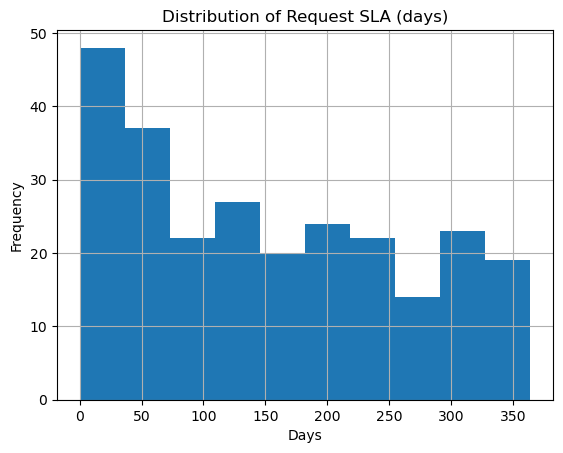

In [8]:
print("Dataset shape:", df.shape)
print("\nData types:")
print(df.dtypes)

# Missing values
print("\nMissing values per column:")
print(df.isna().sum())

# SLA durations
df['request_SLA_days'] = (df['cr date closed'] - df['cr date created']).dt.days
df['testing_SLA_days'] = (df['test results approved date'] - df['test results received date']).dt.days

# Cap extreme open requests at < 365 days
# Business assumption: in real operations, a request should not stay open more than one year.
df = df[df['request_SLA_days'] < 365]

fig, ax = plt.subplots()
df['request_SLA_days'].hist(ax=ax)
ax.set_title("Distribution of Request SLA (days)")
ax.set_xlabel("Days")
ax.set_ylabel("Frequency")
plt.show()

In [9]:
## 2. Feature Engineering

In [10]:
# Binary target: breach if request_SLA_days > 5
SLA_THRESHOLD = 5
df['breach'] = (df['request_SLA_days'] > SLA_THRESHOLD).astype(int)

# Base features
df['month'] = df['cr date created'].dt.month
df['year'] = df['cr date created'].dt.year

feature_cols = [
    'request_SLA_days', 'testing_SLA_days', 'month', 'year', 'category'
]

X = df[feature_cols]
y = df['breach']

# Categorical cols
cat_features = ['category']
num_features = ['request_SLA_days', 'testing_SLA_days', 'month', 'year']

# Preprocess: one‑hot encode category
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
        ('num', 'passthrough', num_features)
    ]
)

In [11]:
## 3. Train/Test Split & Model Training

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Logistic Regression pipeline
logreg_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

# Gradient Boosting pipeline
gb_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', GradientBoostingClassifier())
])

models = {
    'LogisticRegression': logreg_pipeline,
    'GradientBoosting': gb_pipeline
}

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    print(f"\n=== {name} ===")
    print("AUC:", round(auc, 3))
    print("Classification Report:\n", classification_report(y_test, y_pred))


=== LogisticRegression ===
AUC: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.99      0.99        72

    accuracy                           0.99        77
   macro avg       0.92      0.99      0.95        77
weighted avg       0.99      0.99      0.99        77


=== GradientBoosting ===
AUC: 0.993
Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.99      0.99        72

    accuracy                           0.99        77
   macro avg       0.92      0.99      0.95        77
weighted avg       0.99      0.99      0.99        77



In [13]:
## 4. Evaluation: ROC Curve

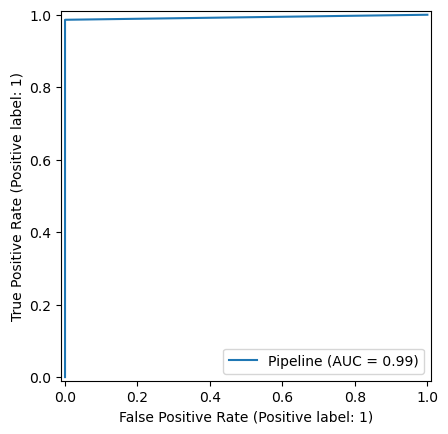

In [14]:
best_model = gb_pipeline  # choose based on AUC above
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.show()

In [15]:
## 5. Save Model Artifact

In [16]:
model_path = "../models/gb_sla_breach_model.pkl"
joblib.dump(best_model, model_path)
print("Model saved to:", model_path)

Model saved to: ../models/gb_sla_breach_model.pkl


In [17]:
# Replace 'your_file.pkl' with the actual path to your PKL file
#file_path = 'your_file.pkl'

# Open the file in binary read mode ('rb') and load the data
with open(model_path, 'rb') as file:
    data = pickle.load(file)

# 'data' now contains the deserialized Python object
print(data)

['request_SLA_days' 'testing_SLA_days' 'month' 'year' 'category']
